In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from google.colab.patches import cv2_imshow
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2



We are gonna define the answer key, in this case it's a 5 questions with 5 possible answers for each of them

In [2]:

# define the answer key. (key = question, value = answer)
ANSWER_KEY = {0: 1, 1: 4, 2: 3, 3: 2, 4: 4}


Load the image. 
Convert it to grayscale to take the edges later on.
Smooth the image to reduce noise.
Take the edges

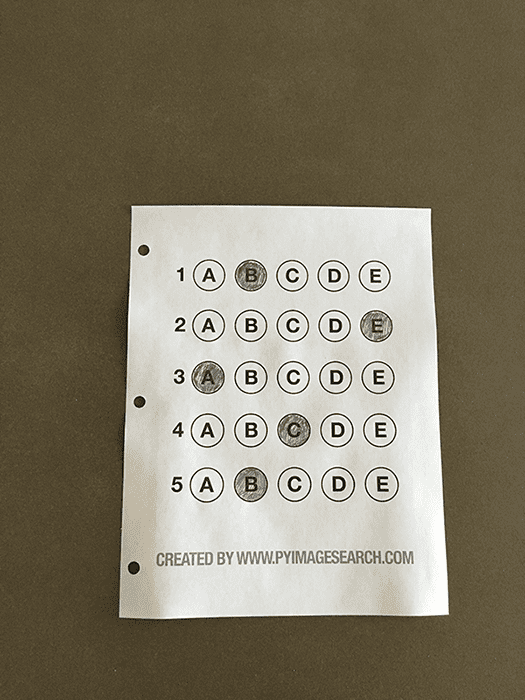

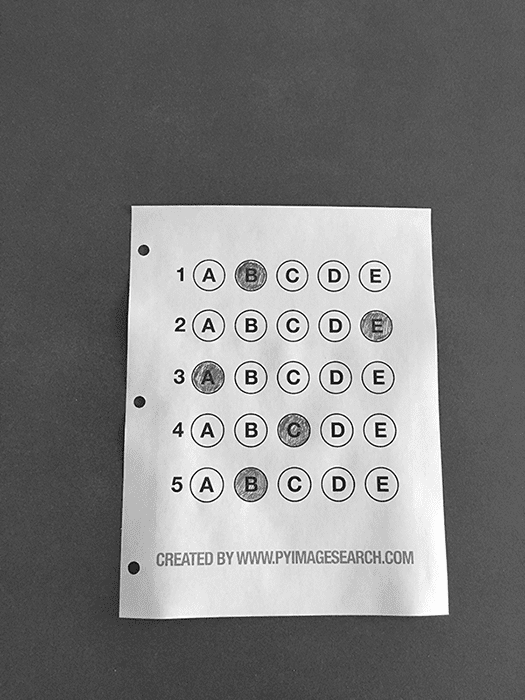

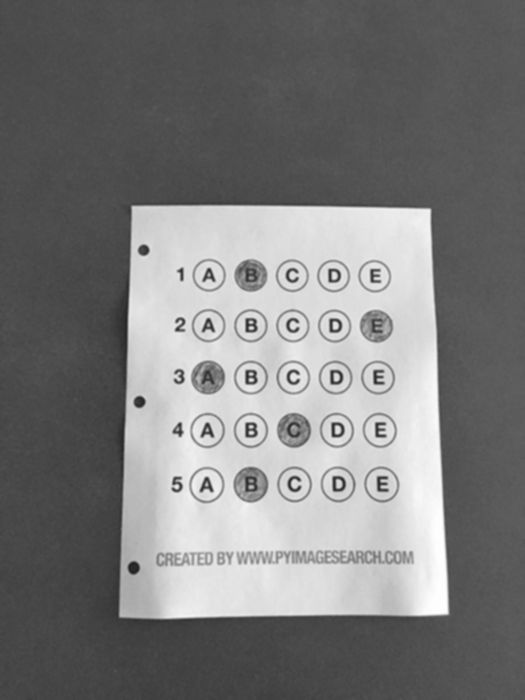

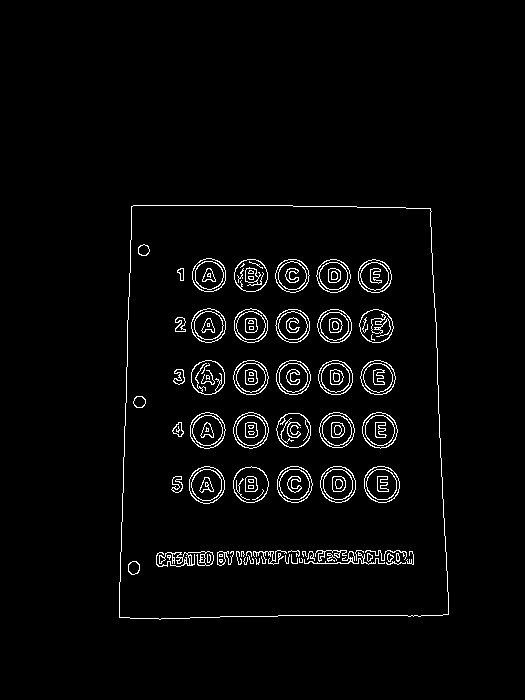

In [6]:
image = cv2.imread("/content/omr_test_01.png") #load image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert it from BGR(RGB is also possible) to gray
blurred = cv2.GaussianBlur(gray, (5, 5), 0) #blurr the image, parameters (x,x) is how blurred we want
edged = cv2.Canny(blurred, 50, 200) #define the edges of the image. numbers are threshold parameters
cv2_imshow(image)
cv2_imshow(gray)
cv2_imshow(blurred)
cv2_imshow(edged)

Now we are gonna find the contours of the edged image, the objective is to map the paper we are scanning

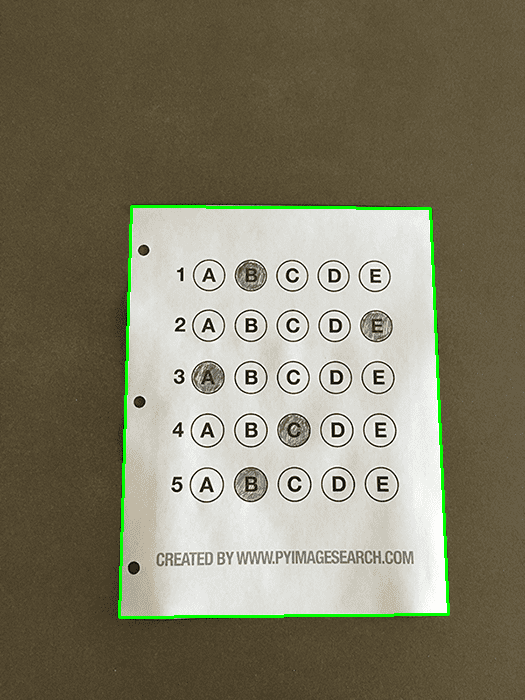

In [7]:
cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE) #this function will find all the contours that define the paper, the questions, the letters etc. Each one will be one contour
cnts = imutils.grab_contours(cnts) #this is just to contours work with different opencv versions
docCnt = None
# ensure that at least one contour was found
if len(cnts) > 0:
	# the goal now is to define the largest contour that can be approximated to a quadrilateral shape and define it as our scanned paper
	# sort the contours according to their size(amount of pixels that define the contours) in descending order	
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points, then we can assume we have found the paper
		if len(approx) == 4:
			docCnt = approx
			break
#we can draw the contour to verify(in any image(original, edged, blurred)), we do it in a copy because somehow the drawContours() alters the image permanently
copy_image = image.copy()
cv2.drawContours(copy_image, [approx], -1, (0, 255, 0), 2)
cv2_imshow(copy_image)

Now we are going to transform the image(original and grayscale) to a top-down birds eye view of the paper by applying a four point perspective
The grayscale we are going to manipulate and the original to show the results

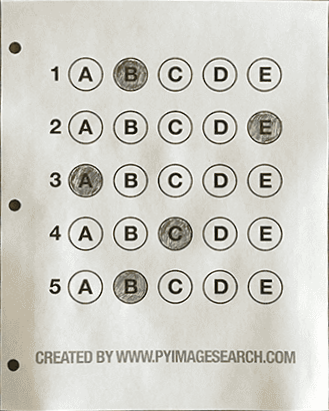

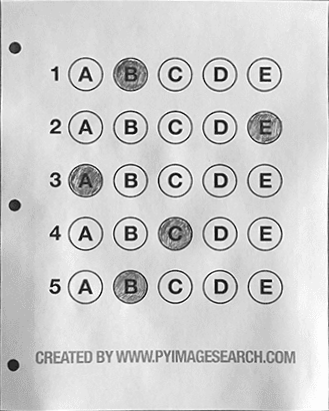

In [8]:
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))
cv2_imshow(paper)
cv2_imshow(warped)

Now we are going to turn the image(warped) all black and white(backgorund black and contours white) by thresholding. pixels values beyond a certain threshold will turn white, and bellow will turn black. Threshold method was Otsu's because the threshold value is choosed automatically

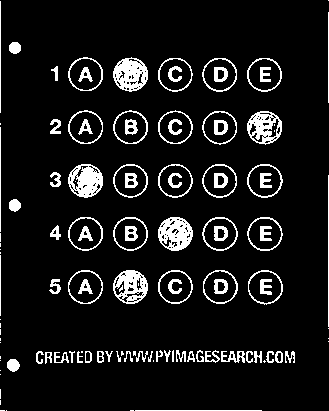

In [9]:
# cv2.threshold ( image, this parameter is irrelevant when using otsu, how white the white is(max pixel vlaue after thresholding), inverted binary method + otsu )
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

Find the contours in the thresholded image

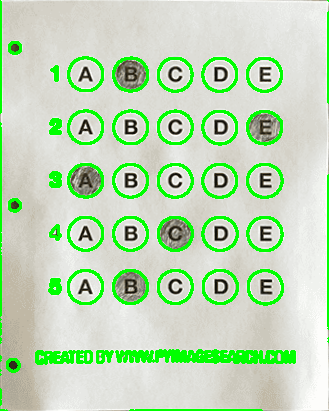

In [10]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#show contours founded in a copy image(warped or paper)
copy_paper = paper.copy()
cv2.drawContours(copy_paper, cnts, -1, (0, 255, 0), 2)
cv2_imshow(copy_paper)

The objective now is to filter the contours that correspond to the questions. To do this we are gonna build a box that bound the contours and calculate the aspect ratio to see if it is a square, if it is then we have found all circles. After that we filter the circles that have a minimum number of pixels (20)

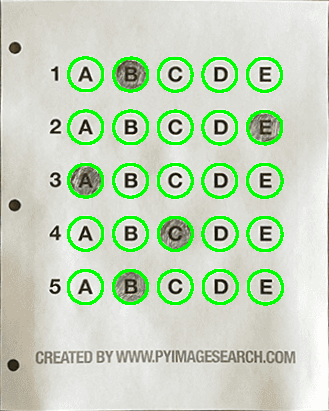

In [11]:
questionCnts = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour, then use the
	# bounding box to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)
	# in order to label the contour as a question, region
	# should be sufficiently wide, sufficiently tall, and
	# have an aspect ratio approximately equal to 1
	if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
		questionCnts.append(c)

#show the results
copy_paper2 = paper.copy()
cv2.drawContours(copy_paper2, questionCnts, -1, (0, 255, 0), 2)
cv2_imshow(copy_paper2)



In [12]:
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = contours.sort_contours(questionCnts,
	method="top-to-bottom")[0]
correct = 0



In [13]:
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
	bubbled = None
		# loop over the sorted contours
	for (j, c) in enumerate(cnts):
		# construct a mask that reveals only the current
		# "bubble" for the question
		mask = np.zeros(thresh.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)
		# apply the mask to the thresholded image, then
		# count the number of non-zero pixels in the
		# bubble area
		mask = cv2.bitwise_and(thresh, thresh, mask=mask)
		total = cv2.countNonZero(mask)
		# if the cu(11,9×1000)×12rrent total has a larger number of total
		# non-zero pixels, then we are examining the currently
		# bubbled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j)
			
	# initialize the contour color and the index of the
	# *correct* answer
	color = (0, 0, 255)
	k = ANSWER_KEY[q]
	# check to see if the bubbled answer is correct
	if k == bubbled[1]:
		color = (0, 255, 0)
		correct += 1
	# draw the outline of the correct answer on the test
	cv2.drawContours(paper, [cnts[k]], -1, color, 3)


[INFO] score: 60.00%


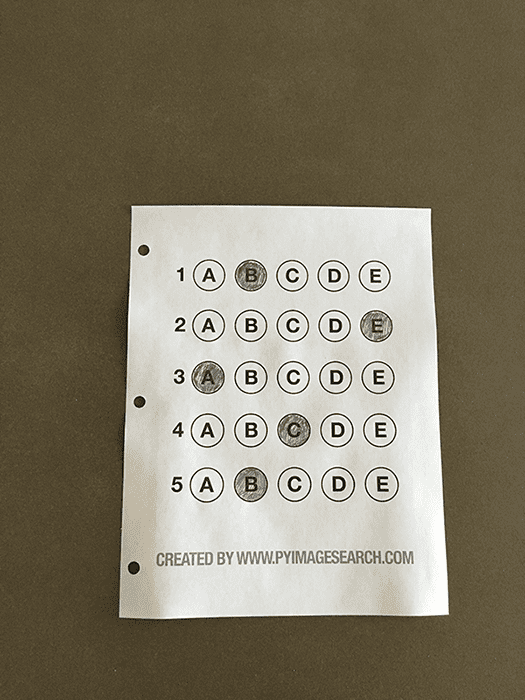

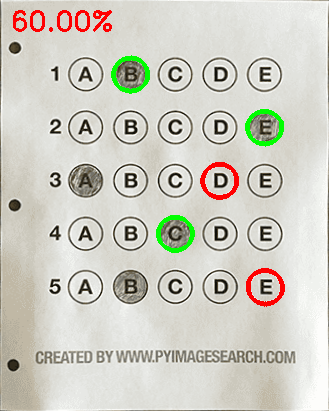

In [14]:
# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
	cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2_imshow(image)
cv2_imshow(paper)
#cv2.waitKey(0)